In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
import h5py

In [3]:
from utils import download_file

filepath_100k = download_file(
    'https://4dn-dcic-public.s3.amazonaws.com/multi_contact_files/100k_test3.hdf5',
    '100k_test3.hdf5',
    base='..'
)

filepath_10k = download_file(
    'https://4dn-dcic-public.s3.amazonaws.com/multi_contact_files/10k_test3.h5',
    '10k_test3.h5',
    base='..'
)

File already exist. To overwrite pass `overwrite=True`
File already exist. To overwrite pass `overwrite=True`


In [223]:
def filter_cluster_data(df, bins):
    '''
    read in clusters h5 file, filter on first anchor bin,
    then loop to filter on subsequent bins
    '''

    with h5py.File(df, 'r') as f:
        data = {'bin': f['clusters']['bin'], 'len': f['clusters']['cluster_name']}
        df = pd.DataFrame(data)
        offsets = np.array(f['index']['bin_offset'][bins[0]:bins[0]+2])

    idx = np.zeros(200000000, dtype='bool')
    clusters = df['len'].iloc[offsets[0]:offsets[1]]
    idx[clusters] = True
    df = df.iloc[idx[df['len'].values]]
    print(len(df))
    for b in bins[1:]:
        idx = np.zeros(200000000, dtype='bool')
        clusters = df['len'][df['bin'] == b]
        idx[clusters] = True
        df = df[idx[df['len'].values]]

    return df

filter_cluster_data(filepath_100k, [10885, 10892, 10814])

280044


,bin,len
187,9,13071167
373,9,41473810
377,9,41597256
550,10,13071167
677,10,33212147
...,...,...
21986889,30543,53562116
21987005,30544,41597256
21987133,30585,45755844
21987401,30889,13071167


In [286]:
import time

class Mc1d:
    def __init__(self, filepath):
        self.filepath = filepath
        self.anchors = []
        
        with h5py.File(filepath, 'r') as f:
            self.bins_to_clusters = np.zeros((len(f['clusters']['bin']), 2)).astype(np.int64)
            self.bins_to_clusters[:,0] = f['clusters']['bin'][:]
            self.bins_to_clusters[:,1] = f['clusters']['cluster_name'][:]

            self.clusters_to_bins = np.zeros((len(f['clusters']['bin']), 2)).astype(np.int64)
            self.clusters_to_bins[:,0] = f['clusters']['cluster_name'][:]
            self.clusters_to_bins[:,1] = f['clusters']['bin'][:]
        
        # Sort by bins for fast access by bins
        self.bins_to_clusters = self.bins_to_clusters[self.bins_to_clusters[:,0].argsort()]
        
        # Sort by bins for fast access by clusters
        self.clusters_to_bins = self.clusters_to_bins[self.clusters_to_bins[:,0].argsort()]
        
        # Bin index
        self.bin_idx = self.get_idx(self.bins_to_clusters[:,0])
        
        # Cluster index
        self.cluster_idx = self.get_idx(self.clusters_to_bins[:,0])
        
        # Cluster index
        self.cluster_mask = np.zeros(self.bins_to_clusters[:,1].max() + 1, dtype='bool')
        
        # Set initial filter mask
        self.filter_masks = [self.get_filter_mask()]
        
    def get_filter_mask(self):
        return np.ones(self.bins_to_clusters.shape[0]).astype(bool)
        
    def get_idx(self, arr):
        # +1 because we need to include the maximum value
        # +1 because we need to prepent a bin for the `-1`th position to
        # later on easily calculate the start and end point
        rle = np.zeros(np.max(arr) + 2)
        curr = arr[0]
        rl = 0
        for i in arr:
            if i == curr:
                rl += 1
            else:
                rle[curr + 1] = rl
                rl = 1
            curr = i
        rle[arr[-1] + 1] = rl
        return np.cumsum(rle).astype(int)
    
    def get_clusters_by_range(self, start, end):
        start = self.bin_idx[start]
        end = self.bin_idx[end]
        
        return self.bins_to_clusters[start:end, 1][self.filter_masks[-1][start:end]]
    
    def get_bins_by_clusters(self, start, end):
        start = self.cluster_idx[start]
        end = self.cluster_idx[end]
        
        return self.clusters_to_bins[start:end, 1]
    
    def get_anchor(self, anchor):
        try:
            start, end = anchor
        except TypeError:
            start = anchor
            end = anchor + 1
            anchor = (anchor, anchor + 1)
        except ValueError:
            start = anchor[0]
            end = anchor + 1

        return (start, end), start, end
    
    def add_anchors(self, *anchors, clear=False):
        for anchor in anchors:
            anchor, start, end = self.get_anchor(anchor)
            
            if anchor in self.anchors:
                raise ValueError('Anchor already set')

            self.anchors.append(anchor)

            clusters = self.get_clusters_by_range(start, end)
            
            t0 = time.time()
            bins = []
            for cluster in np.nditer(clusters):
                bins.append(self.get_bins_by_clusters(cluster, cluster + 1))
            bins = np.concatenate(bins, axis=0)
            print('Clusters to bins took {} msec'.format((time.time() - t0) * 1000))

            t0 = time.time()
            self.cluster_mask[clusters] = True
            mask = self.cluster_mask[self.bins_to_clusters[:,1]]
            print('Mask took {} msec'.format((time.time() - t0) * 1000))
            # New Boolean mask
            self.filter_masks.append(mask)
            
            print(bins, bins.shape)
            print(mask, mask.sum())
            print(self.bins_to_clusters[mask][:,0])
            assert np.array_equal(
                np.sort(self.bins_to_clusters[mask][:,0]),
                np.sort(bins)
            )

            self.cluster_mask[clusters] = False
        if clear:
            i = len(anchors)
            while i > 0:
                self.anchors.pop()
                self.filter_masks.pop()
                i -= 1
    
    def remove_anchors(self, *anchors):
        if len(anchors) == 0:            
            try:
                self.anchors.pop()
                self.filter_masks.pop()
            except IndexError:
                pass
        
        for anchor in anchors:
            anchor, _, _ = self.get_anchor(anchor)
            if anchor in self.anchors:
                last_anchor = self.anchors.pop()
                self.filter_masks.pop()
                keep_anchors = []
                while last_anchor != anchor:
                    keep_anchors.append(last_anchor)
                    last_anchor = self.anchors.pop()
                    self.filter_masks.pop()

                self.add_anchors(*keep_anchors)
        
    def data(self):
        return self.bins_to_clusters[self.filter_masks[-1]]
    
mc1d_100k = Mc1d(filepath_100k)

In [287]:
mc1d_100k.add_anchors(10885, 10892, 10814)

Clusters to bins took 7.338047027587891 msec
Mask took 259.8450183868408 msec
[10681 10885 10898 ... 10880 11776 10906] (280044,)
[False False False ... False  True False] 280044
[    8     9     9 ... 30889 30889 30889]
Clusters to bins took 0.9570121765136719 msec
Mask took 264.6670341491699 msec
[11711 10875 11722 ... 10892 11058 10885] (234065,)
[False False False ... False  True False] 234065
[    8     9     9 ... 30889 30889 30889]
Clusters to bins took 0.37407875061035156 msec
Mask took 268.0060863494873 msec
[10822 10811 11005 ... 22748  9849  2248] (174022,)
[False False False ... False  True False] 174022
[    9     9     9 ... 30585 30889 30889]


In [294]:
x = np.array([[1,1,1,2,3,4,4,5,5,5,6],[1,2,3,1,1,1,4,4,5,6,5]]).T
h = np.histogram(x[:,0], bins=np.arange(x[:,0].min(),x[:,0].max() + 2))
h[0]

array([3, 1, 1, 2, 3, 1])

In [292]:
x[:,0].max()

6

In [243]:
%timeit mc1d_100k.add_anchors(10814, clear=True)

249 ms ± 4.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [237]:
%timeit filter_cluster_data(filepath_100k, [10885, 10892, 10814])

280044
280044
280044
280044
280044
280044
280044
280044
766 ms ± 4.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [221]:
mc1d_100k.remove_anchors(10892)

anchor (10814, 10815)
curr filter mask: (21987539,)
cluster shape: (47,) [1187427 1380659 2466208 3985719 5592739]
new filter mask: (21987539,)


In [222]:
print(
    'anchors', mc1d_100k.anchors,
    'data:', mc1d_100k.data().shape
)

anchors [(10885, 10886), (10814, 10815)] data: (187056, 2)


In [256]:
x = np.array([1,1,1,1,1,2,3,4,5,5,5,6,6,6,6,6,10,10])

b = np.lib.stride_tricks.as_strided(x, (1, 5), 2 * x.strides)
b

array([[1, 1, 1, 1, 1]])

In [5]:
def filter_cluster_data_updated(filename, anchors=[]):
    '''
    read in clusters h5 file, filter on first anchor bin,
    then loop to filter on subsequent bins
    '''

    with h5py.File(filename, 'r') as f:
        data = pd.DataFrame({
            'bin': f['clusters']['bin'],
            'cluster': f['clusters']['cluster_name']
        })
        
        data = np.zeros((len(f['clusters']['bin']), 2))
        # First column holds bins and second column holds clusters
        data[:,0] = f['clusters']['bin'][:]
        data[:,1] = f['clusters']['cluster_name'][:]
        
        bins_sorted = np.sort(data[:,0])
        clusters_sorted_by_bins = data[:,1][np.argsort(data[:,0])]
    
    cluster_idx = np.zeros(clusters.max() + 1, dtype='bool')
    
    for anchor in anchors:
        # First index of the anchor bin
        start = np.searchsorted(bins_sorted, anchor)
        # First index that is not part of the anchor anymore
        end = np.searchsorted(bins_sorted, anchor, side='right')
        # Cluster within the anchor
        clusters = clusters_sorted_by_bins[start:end]
        # Update cluster index
        cluster_idx[clusters] = True
        # Cluster mask for all bins related to the selected cluster
        cluster_mask = cluster_idx[clusters]
        # 
        data = data[:,cluster_idx[data['cluster'].values]]
        cluster_idx[clusters] = False
        
    return data

filter_cluster_data_updated(filepath_100k, [10885, 10892, 10814])

UnboundLocalError: local variable 'clusters' referenced before assignment

In [6]:
def filter_cluster_data_original(df, bins):
    '''
    read in clusters h5 file, filter on first anchor bin,
    then loop to filter on subsequent bins
    '''
    offsets = np.array(f['index']['bin_offset'][bins[0]:bins[0]+2])
    idx = np.zeros(200000000, dtype='bool')
    clusters = df['cluster'].iloc[offsets[0]:offsets[1]]
    idx[clusters] = True
    df = df.iloc[idx[df['cluster'].values]]
    for b in bins[1:]:
        idx = np.zeros(200000000, dtype='bool')
        clusters = df['cluster'][df['bin'] == b]
        idx[clusters] = True
        df = df[idx[df['cluster'].values]]

    return df

In [7]:
def prepare_data(filepath):
    with h5py.File(filepath, 'r') as f:
        data = pd.DataFrame({
            'bin': f['clusters']['bin'],
            'cluster': f['clusters']['cluster_name']
        })
        
        data.set_index(['bin', 'cluster'])
        
    return data

def filter_cluster_data_new(data, anchors=[]):
    '''
    read in clusters h5 file, filter on first anchor bin,
    then loop to filter on subsequent bins
    ''' 
    
    max_cluster_name = data['cluster'].max() + 1
    cluster_idx = np.zeros(max_cluster_name, dtype='bool')
    
    for anchor in anchors:
        clusters = data['cluster'][data['bin'] == anchor]
        cluster_idx[clusters] = True
        data = data.iloc[cluster_idx[data['cluster'].values]]
        cluster_idx[clusters] = False
        
    return data

In [ ]:
data = prepare_data(filepath_10k)

In [12]:
# filter_cluster_data_original(data, [10885, 10892, 10814])
filter_cluster_data_new(data, [10885, 10892, 10814])

,bin,cluster
213,91,41597256
708,99,41597256
863,102,41597256
923,103,41597256
1091,106,41597256
...,...,...
33989910,305233,41597256
33990986,305259,41597256
33991092,305262,41597256
33991699,305345,41597256


In [13]:
%timeit filter_cluster_data_new(data, [10885, 10892, 10814])

528 ms ± 42.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
def plot_genomic_enrichment_scatter(data, start, end):
    '''
    scatter plot of bins in filtered clusters, from start bin to end bin
    '''
    subset = data[(data['bin'] >= start) & (data['bin'] <= end)]
    #data_sorted = subset.sort_values(by=['len'])
    locs = subset['bin'].values
    clusters = subset['len'].values
    print(len(locs))
    print(len(clusters))
    fig = plt.figure(figsize=(18,6))
    ax = fig.add_subplot(111)
    ax.scatter(locs[:5000], clusters[:5000], s=2)
    plt.yticks([])

    plt.show()

In [14]:
def plot_genomic_enrichment_line(data, start, end):
    '''
    line plot - # of each bin in filtered dataframe
    '''
    subset = data[(data['bin'] >= start) & (data['bin'] <= end)]
    counts = subset.groupby('bin').count()
    locs = counts.index.values
    clusters = counts['len'].values

    fig = plt.figure(figsize=(18,6))
    ax = fig.add_subplot(111)
    ax.plot(locs[:5000], clusters[:5000])
    ax.fill_between(locs[:5000], list(clusters[:5000]), color='blue')
    #plt.yticks([])

    plt.show()

In [ ]:
tileset_boston = Tileset(
    tileset_info=lambda: tileset_info(temps_by_city['boston']),
    tiles=lambda tile_ids: tiles_wrapper(temps_by_city['boston'], tile_ids),
    name='Boston'
)

def mc_1d(filepath, anchors=[], **kwargs):
    """
    Tileset for multicontact 1D data
    """
    
    tile_size = 1024
    
    def filter_data(filepath, anchors=[]):
        with h5py.File(filepath, 'r') as f:
            data = pd.DataFrame({
                'bin': f['clusters']['bin'],
                'cluster': f['clusters']['cluster_name']
            })
            
            min_pos = data['bin'].values.min()
            max_pos = data['bin'].values.max()
        
        counts_by_bin = np.zero(max_pos - min_pos)

        max_cluster_name = data['cluster'].max() + 1
        cluster_idx = np.zeros(max_cluster_name, dtype='bool')

        for anchor in anchors:
            clusters = data['cluster'][data['bin'] == anchor]
            cluster_idx[clusters] = True
            data = data.iloc[cluster_idx[data['cluster'].values]]
            cluster_idx[clusters] = False

        counts = data.groupby('bin').count()
        counts_by_bin[counts.index.values] = counts['len'].values

        return counts_by_bin, min_pos, max_pos
    
    data, min_pos, max_pos = filter_data(filepath, anchors)
    
    data_size = data.size
    not_nan_data = ~np.isnan(data)
    
    max_zoom = math.ceil(math.log(max_pos / tile_size) / math.log(2))
    max_zoom = 0 if max_zoom < 0 else max_zoom

    tsinfo = {
        'tile_size': tile_size,
        'bins_per_dimension': tile_size,
        'min_pos': [min_pos],
        'max_pos': [max_pos],
        'max_zoom': max_zoom,
        'max_width': 2 ** max_zoom * 1024,
    }


    def generate_tile(z, x, not_nan_array=None):
        '''
        Return tiles at the given positions.
        Parameters
        -----------
        array: np.array
            An nxn array containing values
        z: int
            The zoom level (0 corresponds to most zoomed out)
        x: int
            The x tile position
        not_nan_array: np.array
            An array storing the number of values which are not nan
            in the original array. Can be precalculated for speed.
        '''
        
        tile_width = 2 ** (max_zoom - z) * tile_size

        x_start = x * tile_width
        x_end = min(max_pos, x_start + tile_width)
        
        data = array[x_start:x_end]

        num_to_sum = 2 ** (max_zoom - z)

        # add some data so that the data can be divided into squares
        divisible_x_width = num_to_sum * math.ceil(data_size / num_to_sum)
        divisible_x_pad = divisible_x_width - data_size

        padded_data = np.pad(
            data, ((0, divisible_x_pad),), 'constant', constant_values=(np.nan,)
        )

        out_data = np.nansum(padded_data.reshape((-1, num_to_sum)), axis=1)
        not_nan_data = not_nan_array[x_start:x_end]

        # we want to calculate the means of the data points
        na = np.pad(
            not_nan_data,
            ((0, divisible_x_pad)),
            'constant',
            constant_values=(np.nan,)
        )
        norm_data = np.nansum(na.reshape((-1, num_to_sum)), axis=1)
        out_data = out_data / (norm_data + 1)

        # determine how much to pad the array
        x_pad = tile_size - out_data.shape[0]

        return np.pad(
            out_data, ((0, x_pad)), 'constant', constant_values=(np.nan, )
        )
    
    def tileset_info():
        return tsinfo
    
    def tiles(tile_ids):
        tiles = []
        
        for tile_id in tile_ids:
            # decompose the tile zoom and location
            _, z, x, y = tile_id.split('.')
            
            # generate the tile
            data = generate_tile(int(z), int(x))
            
            # format the tile response
            tiles.append((tile_id, format_dense_tile(data)))
    
        return tiles
    

    return Tileset(
        tileset_info=tileset_info,
        tiles=tiles,
        **kwargs
    )

701
701


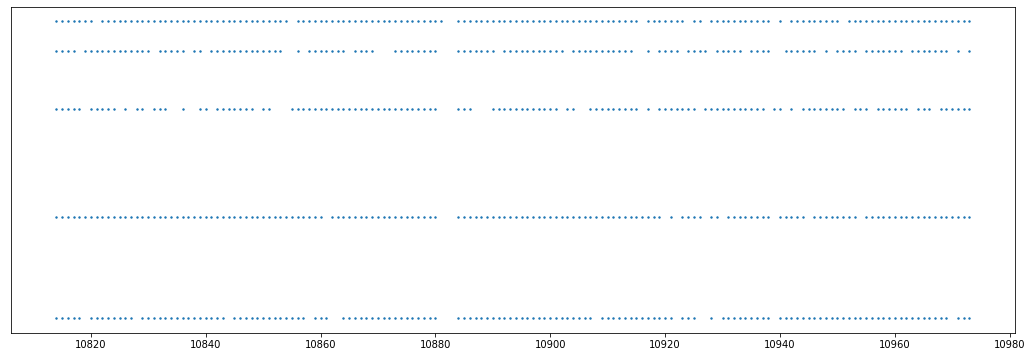

In [12]:
df = filter_cluster_data(file_100k, [10885, 10892, 10814, 10973])
plot_genomic_enrichment(df, 10814, 10973)

4427
4427


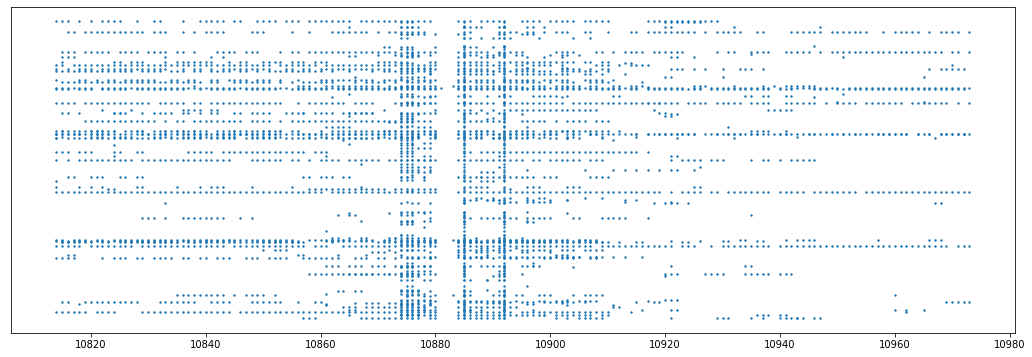

In [13]:
df = filter_cluster_data(file_100k, [10885, 10892])
plot_genomic_enrichment(df, 10814, 10973)

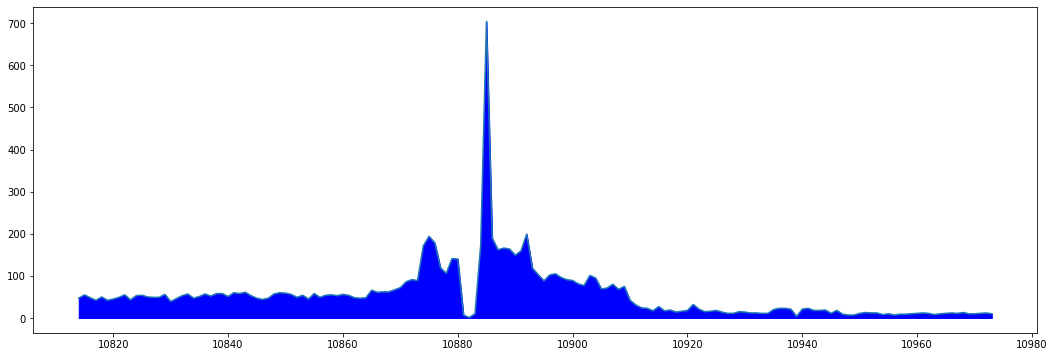

In [15]:
df1 = filter_cluster_data(file_100k, [10885])
plot_genomic_enrichment_line(df1, 10814, 10973)

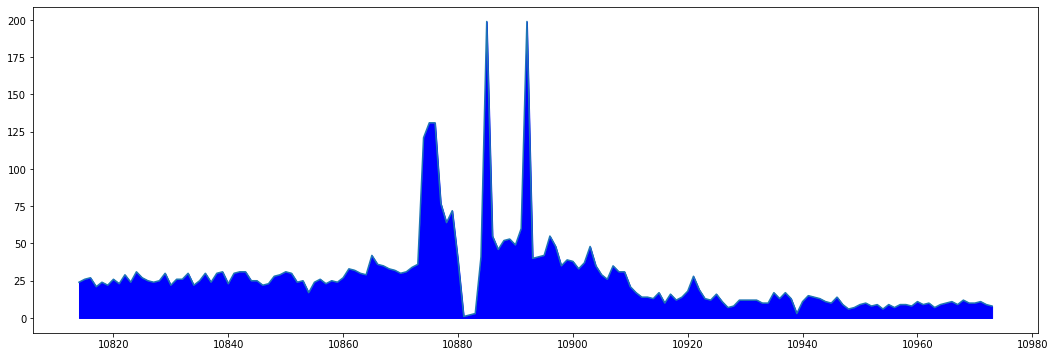

In [16]:
df2 = filter_cluster_data(file_100k, [10885, 10892])
plot_genomic_enrichment_line(df2, 10814, 10973)

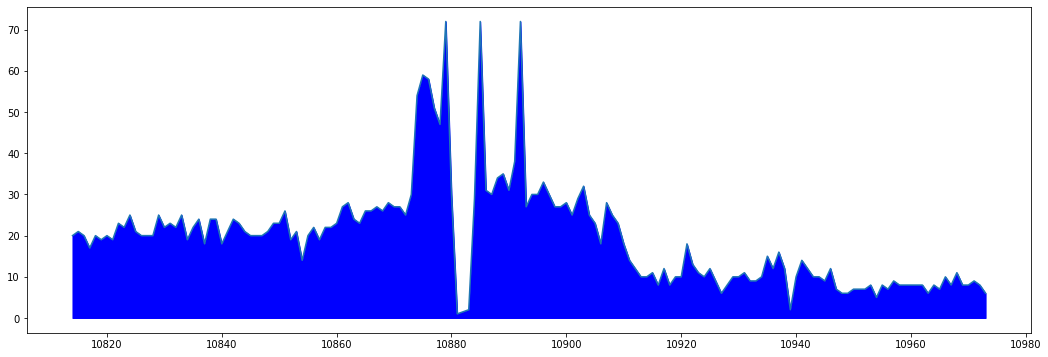

In [17]:
df3 = filter_cluster_data(file_100k, [10885, 10892, 10879])
plot_genomic_enrichment_line(df3, 10814, 10973)

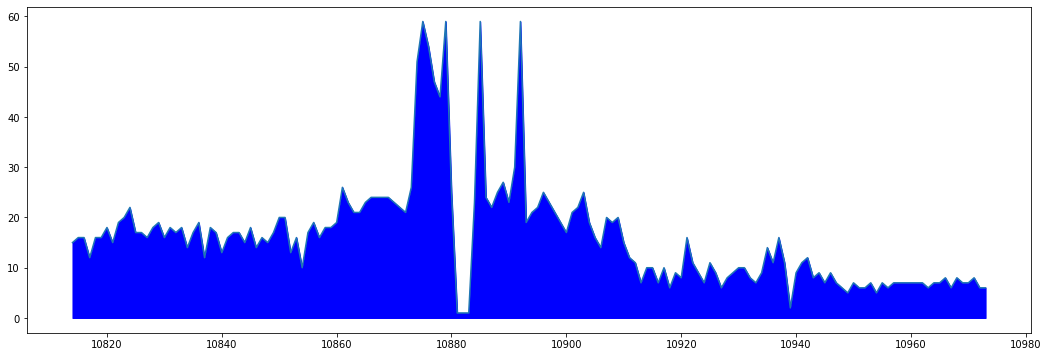

In [18]:
df4 = filter_cluster_data(file_100k, [10885, 10892, 10879, 10875])
plot_genomic_enrichment_line(df4, 10814, 10973)

In [19]:
# show some locations of 10k bins
with h5py.File(file_10k, 'r') as f:
    bin_dict = {'chr': f['bins']['chrom'], 'start': f['bins']['start'], 'end': f['bins']['end']}
    bins = pd.DataFrame(bin_dict)


In [20]:
bins.iloc[108836]

chr             5
start    27140000
end      27150000
Name: 108836, dtype: int32

In [21]:
bins.iloc[108907]

chr             5
start    27850000
end      27860000
Name: 108907, dtype: int32

In [22]:
%timeit filter_cluster_data(file_10k, [108836, 108907])

1.04 s ± 53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%timeit filter_cluster_data(file_10k, [108836, 108907, 108750])

1.15 s ± 16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


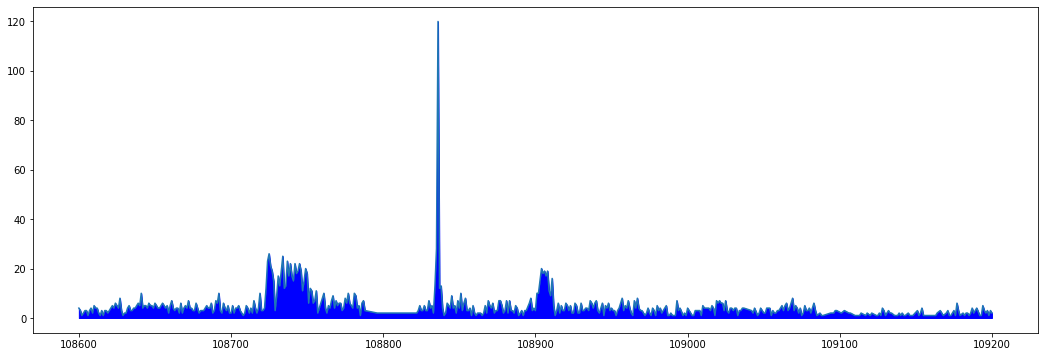

In [24]:
df11 = filter_cluster_data(file_10k, [108836])
plot_genomic_enrichment_line(df11, 108600, 109200)

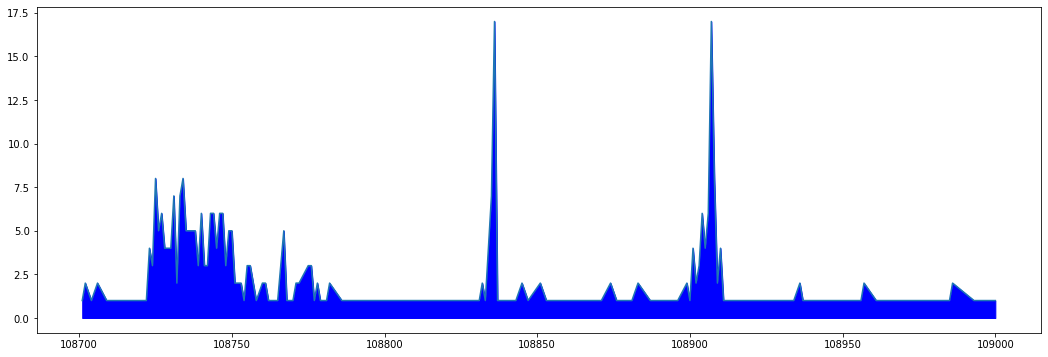

In [25]:
df12 = filter_cluster_data(file_10k, [108836, 108907])
plot_genomic_enrichment_line(df12, 108700, 109000)

In [26]:
df12.shape

(18869, 2)